In [1]:
import requests
from IPython.display import Markdown
from tqdm import tqdm, tqdm_notebook
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt
from requests.utils import quote
import os
from github import Github

In [2]:
end_date = "2019-06-01"
start_date = "2019-05-01"
renderer = "jupyterlab"

In [3]:
# Create the renderer we want
alt.renderers.enable(renderer)

RendererRegistry.enable('jupyterlab')

In [4]:
# Discourse API key
api = {'Api-Key': os.environ['DISCOURSE_API_KEY'],
       'Api-Username': os.environ['DISCOURSE_API_USERNAME']}

In [39]:
# Discourse
def topics_to_markdown(topics, n_list=10):
    body = []
    for _, topic in topics.iterrows():
        title = topic['fancy_title']
        slug = topic['slug']
        posts_count = topic['posts_count']
        url = f'https://discourse.jupyter.org/t/{slug}'
        body.append(f'* [{title}]({url}) ({posts_count} posts)')
    body = body[:n_list]
    return '\n'.join(body)

def counts_from_activity(activity):
    counts = activity.groupby('category_id').count()['bookmarked'].reset_index()
    counts['parent_category'] = None
    for ii, irow in counts.iterrows():
        if parent_categories[irow['category_id']] is not None:
            counts.loc[ii, 'parent_category'] = parent_categories[irow['category_id']]

    counts['category_id'] = counts['category_id'].map(lambda a: category_mapping[a])
    counts['parent_category'] = counts['parent_category'].map(lambda a: category_mapping[a] if a is not None else 'parent')
    is_parent = counts['parent_category'] == 'parent'
    counts.loc[is_parent, 'parent_category'] = counts.loc[is_parent, 'category_id'] 
    counts['parent/category'] = counts.apply(lambda a: a['parent_category']+'/'+a['category_id'], axis=1)
    counts = counts.sort_values(['parent_category', 'bookmarked'], ascending=False)
    return counts

# GitHub
def run_github_query(query, github_base="https://api.github.com/search/issues"):
    gh = Github(os.environ["GITHUB_ACCESS_TOKEN"])
    resp = gh.search_issues(query)
    data = []
    for ii in range(0, 10):
        items = resp.get_page(ii)
        if len(items) > 0:
            items_list = [item.raw_data for item in items]
            data.append(pd.DataFrame.from_records(items_list))
        else:
            break
    if len(data) == 0:
        return pd.DataFrame([])
    else:
        return pd.concat(data)
    


# Community forum activity

The [Jupyter Community Forum](https://discourse.jupyter.org) is a place for Jovyans across the
community to talk about Jupyter tools in interactive computing and how they fit into their
workflows. It's also a place for developers to share ideas, tools, tips, and help one another.

Below are a few updates from activity in the Discourse. For more detailed information about
the activity on the Community Forum, check out these links:

* [The users page](https://discourse.jupyter.org/u) has information about user activity
* [The top posts page](https://discourse.jupyter.org/top) contains a list of top posts, sorted
  by various metrics.

In [6]:
# Get categories for IDs
url = "https://discourse.jupyter.org/site.json"
resp = requests.get(url, headers=api)
category_mapping = {cat['id']: cat['name'] for cat in resp.json()['categories']}
parent_categories = {cat['id']: cat.get("parent_category_id", None) for cat in resp.json()['categories']}

In [7]:
# Base URL to use
url = "https://discourse.jupyter.org/latest.json"

## Topics with lots of likes

"Likes" are a way for community members to say thanks for a helpful post, show their
support for an idea, or generally to share a little positivity with somebody else.
These are topics that have generated lots of likes in recent history.

In [8]:
params = {"order": "likes", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Topics with the most likes in recent history
liked = pd.DataFrame(resp.json()['topic_list']['topics'])
Markdown(topics_to_markdown(liked))

* [Introduce yourself!](https://discourse.jupyter.org/t/introduce-yourself) (93 posts)
* [{WIP} Re-Design of Jupyter.org Website](https://discourse.jupyter.org/t/wip-re-design-of-jupyter-org-website) (29 posts)
* [Jupyter Community Calls](https://discourse.jupyter.org/t/jupyter-community-calls) (27 posts)
* [Help us choose an updated &ldquo;Launch Binder&rdquo; badge!](https://discourse.jupyter.org/t/help-us-choose-an-updated-launch-binder-badge) (21 posts)
* [PyCon 2019 and mybinder.org](https://discourse.jupyter.org/t/pycon-2019-and-mybinder-org) (17 posts)
* [The Binder Federation](https://discourse.jupyter.org/t/the-binder-federation) (14 posts)
* [Jupyter community workshop: proposal on diversity, inclusion and accessibility](https://discourse.jupyter.org/t/jupyter-community-workshop-proposal-on-diversity-inclusion-and-accessibility) (20 posts)
* [Sunset the GitHub repo jupyter/help?](https://discourse.jupyter.org/t/sunset-the-github-repo-jupyter-help) (17 posts)
* [Binder/BinderHub Workshops &ndash; Help Wanted!](https://discourse.jupyter.org/t/binder-binderhub-workshops-help-wanted) (25 posts)
* [Creating a new Binder-at-home tool](https://discourse.jupyter.org/t/creating-a-new-binder-at-home-tool) (13 posts)

## Active topics on Discourse

These are topics with lots of activity in recent history.

In [9]:
params = {"order": "posts", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Topics with the most posts in recent history
posts = pd.DataFrame(resp.json()['topic_list']['topics'])
Markdown(topics_to_markdown(posts))

* [Introduce yourself!](https://discourse.jupyter.org/t/introduce-yourself) (93 posts)
* [Tip: embed custom github content in a Binder link with nbgitpuller](https://discourse.jupyter.org/t/tip-embed-custom-github-content-in-a-binder-link-with-nbgitpuller) (31 posts)
* [Would a &ldquo;The Littlest Binder&rdquo; be useful?](https://discourse.jupyter.org/t/would-a-the-littlest-binder-be-useful) (30 posts)
* [{WIP} Re-Design of Jupyter.org Website](https://discourse.jupyter.org/t/wip-re-design-of-jupyter-org-website) (29 posts)
* [Plugins of considerations](https://discourse.jupyter.org/t/plugins-of-considerations) (28 posts)
* [Jupyter Community Calls](https://discourse.jupyter.org/t/jupyter-community-calls) (27 posts)
* [A proposal for JupyterHub communications](https://discourse.jupyter.org/t/a-proposal-for-jupyterhub-communications) (26 posts)
* [Binder/BinderHub Workshops &ndash; Help Wanted!](https://discourse.jupyter.org/t/binder-binderhub-workshops-help-wanted) (25 posts)
* [Help us choose an updated &ldquo;Launch Binder&rdquo; badge!](https://discourse.jupyter.org/t/help-us-choose-an-updated-launch-binder-badge) (21 posts)
* [Potential collaboration on user research?](https://discourse.jupyter.org/t/potential-collaboration-on-user-research) (21 posts)

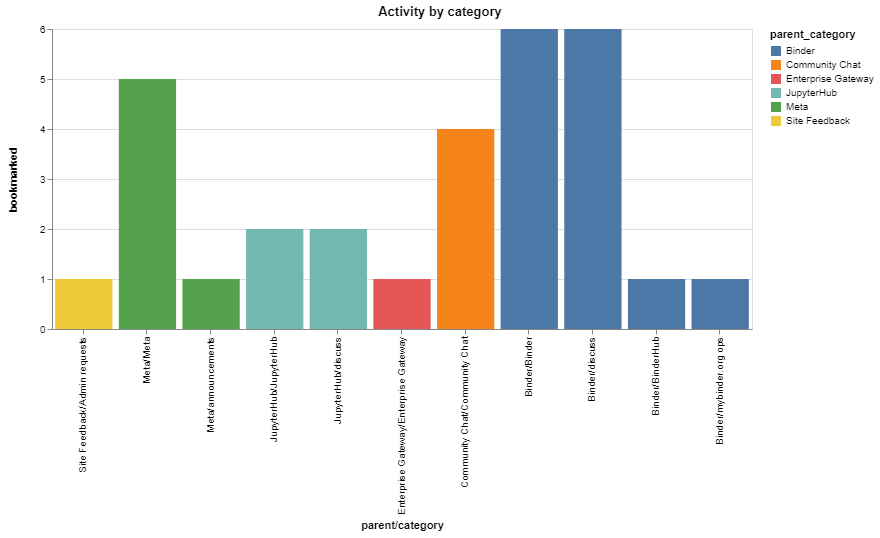

In [10]:
counts = counts_from_activity(posts)
alt.Chart(data=counts, width=700, height=300, title="Activity by category").mark_bar().encode(
    x=alt.X("parent/category", sort=alt.Sort(counts['category_id'].values.tolist())),
    y="bookmarked",
    color="parent_category"
)

## Recently-created topics

These are topics that were recently created, sorted by the amount of activity
in each one.

In [11]:
params = {"order": "created", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Sort created by the most posted for recently-created posts
created = pd.DataFrame(resp.json()['topic_list']['topics'])
created = created.sort_values('posts_count', ascending=False)
Markdown(topics_to_markdown(created))

* [I get `Read timed out` errors on when pushing image OVH](https://discourse.jupyter.org/t/i-get-read-timed-out-errors-on-when-pushing-image-ovh) (8 posts)
* [JupyterHub, Binder workshop](https://discourse.jupyter.org/t/jupyterhub-binder-workshop) (8 posts)
* [Internal Server Error with notebook with conda dependencies](https://discourse.jupyter.org/t/internal-server-error-with-notebook-with-conda-dependencies) (7 posts)
* [JupyterLab 1.0 Release Candidate published](https://discourse.jupyter.org/t/jupyterlab-1-0-release-candidate-published) (5 posts)
* [Quick question on jupyterlab doc regarding &lt;lab-location&gt;](https://discourse.jupyter.org/t/quick-question-on-jupyterlab-doc-regarding-lab-location) (4 posts)
* [0.5 G for memory limit?](https://discourse.jupyter.org/t/0-5-g-for-memory-limit) (4 posts)
* [Document domain registration for JupyterHub](https://discourse.jupyter.org/t/document-domain-registration-for-jupyterhub) (4 posts)
* [Welcoming our new JupyterHub team member: Sarah!](https://discourse.jupyter.org/t/welcoming-our-new-jupyterhub-team-member-sarah) (3 posts)
* [Please take the mybinder.org user survey](https://discourse.jupyter.org/t/please-take-the-mybinder-org-user-survey) (3 posts)
* [Problem Triggering Binder Build through API endpoint](https://discourse.jupyter.org/t/problem-triggering-binder-build-through-api-endpoint) (3 posts)

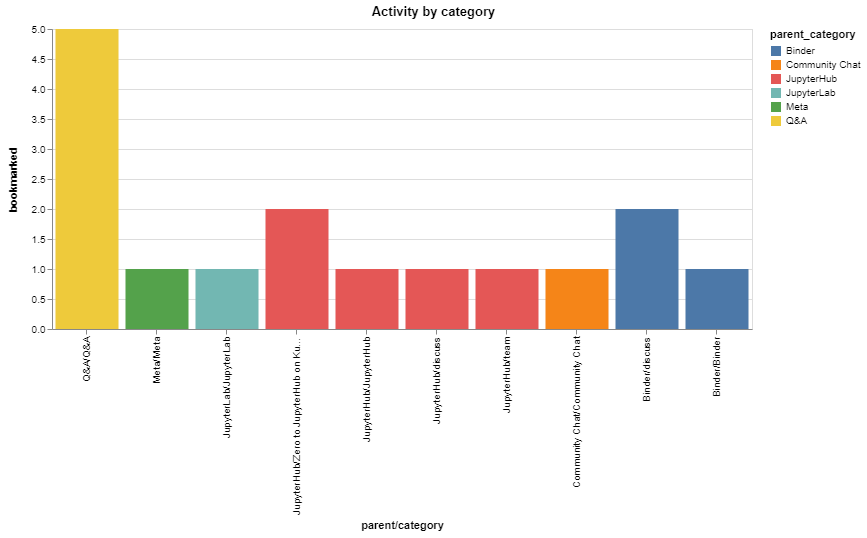

In [12]:
counts = counts_from_activity(created)
alt.Chart(data=counts, width=700, height=300, title="Activity by category").mark_bar().encode(
    x=alt.X("parent/category", sort=alt.Sort(counts['category_id'].values.tolist())),
    y="bookmarked",
    color="parent_category"
)

# GitHub activity

Jupyter also has lots of activity across GitHub repositories. The following sections contain
overviews of recent activity across the following GitHub organizations:

* [github.com/jupyterhub](https://github.com/jupyterhub)
* [github.com/jupyter](https://github.com/jupyter)
* [github.com/jupyterlab](https://github.com/jupyterlab)
* [github.com/jupyter-widgets](https://github.com/jupyter-widgets)

In [32]:
from datetime import timedelta

orgs = ["jupyterhub", "jupyter", "jupyterlab", "jupyter-widgets", "ipython", "binder-examples"]
Markdown(f"Showing GitHub activity from **{start_date}** to **{end_date}**")

Showing GitHub activity from **2019-05-01** to **2019-06-01**

## Merged Pull requests

Here's an analysis of **merged pull requests** across each of the repositories in the Jupyter
ecosystem.

In [33]:
# Update data
merged = []
for org in tqdm(orgs):
    query = f"is:merged user:{org} archived:false closed:{start_date}..{end_date}"
    this_merged = run_github_query(query)
    this_merged['org'] = org
    merged.append(this_merged)
merged = pd.concat(merged)
merged['repo'] = merged['repository_url'].map(lambda a: a.split('/')[-1])

# Count PRs by org/repo
prs_by_repo = merged.groupby(['org', 'repo']).count()['body'].reset_index().sort_values(['org', 'body'], ascending=False)

100%|██████████| 6/6 [02:11<00:00, 16.40s/it]


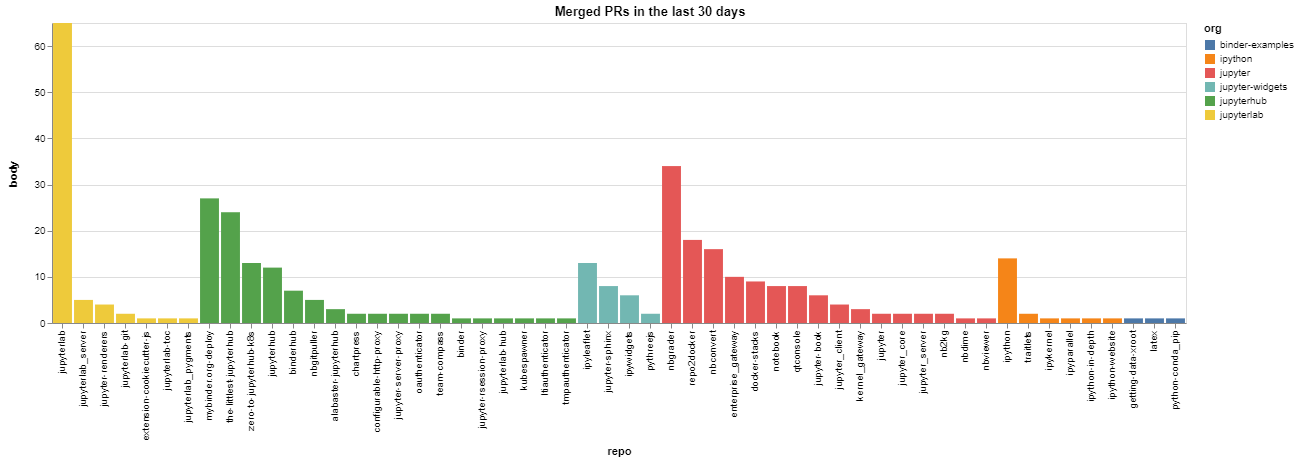

In [34]:
alt.Chart(data=prs_by_repo, title="Merged PRs in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=prs_by_repo['repo'].values.tolist()),
    y='body',
    color='org'
)

### A list of merged PRs by project

In [46]:
from ipywidgets import widgets, HTML
from ipywidgets import HTML
from markdown import markdown 

In [36]:
tabs = widgets.Tab(children=[])
for ii, (org, idata) in enumerate(merged.groupby('org')):
    issue_md = []
    issue_md.append(f"#### Closed PRs for org: `{org}`")
    issue_md.append("")
    for repourl, prs in idata.groupby('repository_url'):
        reponame, repo = repourl.split('/')[-2:]
        issue_md.append(f"##### [{reponame}/{repo}](https://github.com/{reponame}/{repo})")
        for _, pr in prs.iterrows():
            user_name = pr['user']['login']
            user_url = pr['user']['html_url']
            pr_number = pr['number']
            pr_html = pr['html_url']
            pr_title = pr['title']
            pr_closedby = pr['closed_by']['login']
            pr_closedby_url = pr['closed_by']['html_url']
            text = f"* [(#{pr_number})]({pr_html}): _{pr_title}_ by **[@{user_name}]({user_url})** merged by **[@{pr_closedby}]({pr_closedby_url})**"
            issue_md.append(text)
    issue_md.append('')
    markdown_html = markdown('\n'.join(issue_md))
    
    children = list(tabs.children)
    children.append(HTML(markdown_html))
    tabs.children = tuple(children)
    tabs.set_title(ii, org)
tabs

## Issues

Issues are **conversations** that happen on our GitHub repositories. Here's an
analysis of issues across the Jupyter organizations.

In [40]:
# Created issues
created = []
for org in tqdm(orgs):
    query = f"is:open is:issue user:{org} archived:false created:{start_date}..{end_date}"
    this_created = run_github_query(query)
    if len(this_created) == 0:
        continue
    this_created['org'] = org
    created.append(this_created)
created = pd.concat(created)
created['repo'] = created['repository_url'].map(lambda a: a.split('/')[-1])


100%|██████████| 6/6 [01:51<00:00, 14.54s/it]

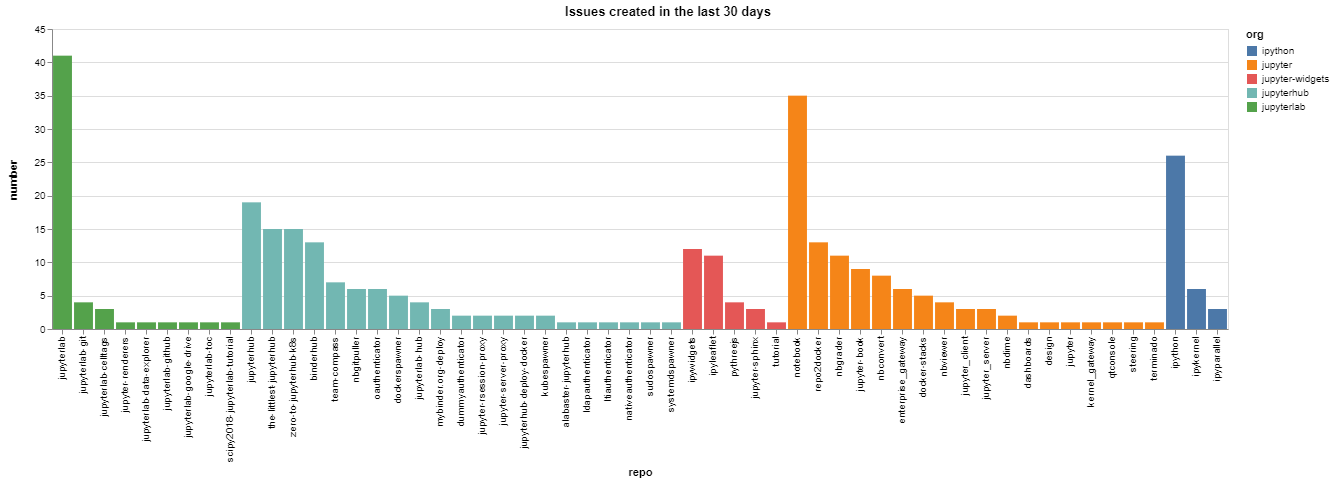

In [41]:
created_counts = created.groupby(['org', 'repo']).count()['number'].reset_index()
created_counts['org/repo'] = created_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = created_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=created_counts, title="Issues created in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

In [42]:
# Closed issues
closed = []
for org in tqdm(orgs):
    query = f"is:issue user:{org} closed:{start_date}..{end_date}"
    this_closed = run_github_query(query)
    this_closed['org'] = org
    closed.append(this_closed)
closed = pd.concat(closed)
closed['repo'] = closed['repository_url'].map(lambda a: a.split('/')[-1])


100%|██████████| 6/6 [01:51<00:00, 13.61s/it]/home/choldgraf/anaconda/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


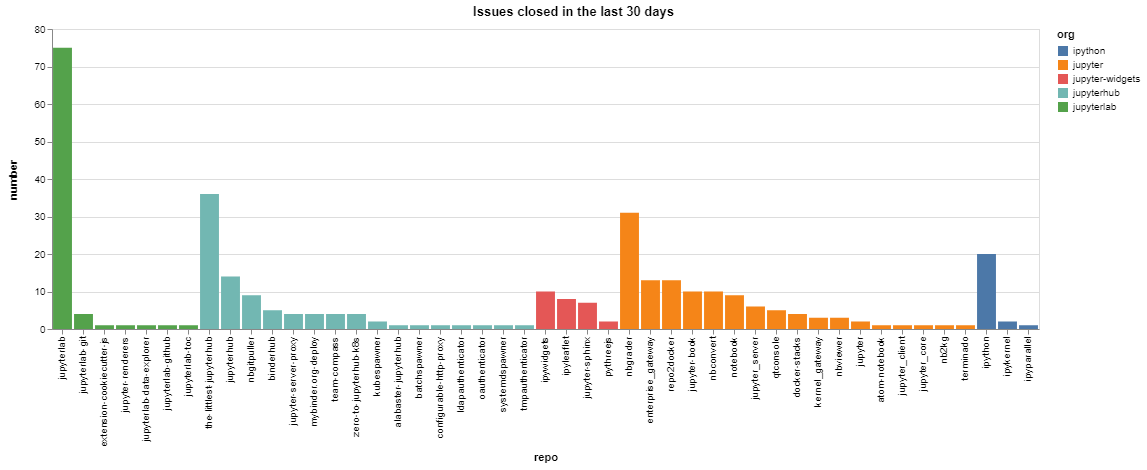

In [43]:
closed_counts = closed.groupby(['org', 'repo']).count()['number'].reset_index()
closed_counts['org/repo'] = closed_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = closed_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=closed_counts, title="Issues closed in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

### A list of recent issues

In [54]:
n_plot = 5
tabs = widgets.Tab(children=[])
for ii, (org, idata) in enumerate(created.groupby('org')):
    issue_md = []
    issue_md.append(f"#### {org}")
    issue_md.append("")
    for repourl, issues in idata.groupby('repository_url'):
        reponame, repo = repourl.split('/')[-2:]
        issue_md.append(f"##### [{reponame}/{repo}](https://github.com/{reponame}/{repo})")
        for _, issue in issues.sort_values('comments', ascending=False).head(n_plot).iterrows():
            user_name = issue['user']['login']
            user_url = issue['user']['html_url']
            issue_number = issue['number']
            issue_html = issue['html_url']
            issue_title = issue['title']

            text = f"* [(#{issue_number})]({issue_html}): _{issue_title}_ by **[{user_name}]({user_url})**"
            issue_md.append(text)
    issue_md.append('')
    md_html = HTML(markdown('\n'.join(issue_md)))
    
    children = list(tabs.children)
    children.append(HTML(markdown('\n'.join(issue_md))))
    tabs.children = tuple(children)
    tabs.set_title(ii, org)
    
display(Markdown(f"Here are the top {n_plot} active issues in each repository in the last 30 days"))
display(tabs)

Here are the top 5 active issues in each repository in the last 30 days